In [1]:
# import modules automatically after changes
%load_ext autoreload
%autoreload 2
# Show plots in the notebook
%matplotlib inline

# Imports

In [131]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import load_config

In [219]:
# Set plot style
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.titleweight"] = "bold"
%config InlineBackend.figure_format = 'retina'
# Set color palette

# Load data

In [7]:
# # set working directory to project root - EXECUTE ONLY ONCE or RESTART KERNEL
# os.chdir('..')
os.getcwd()

'C:\\Users\\merti\\PycharmProjects\\sem-outbreak-detection'

In [21]:
# Load configs
config = load_config("config.yaml")

In [126]:
# Get data
df_recently_puplished = pd.read_csv(
    config["data"]["data_recently_puplished"],
    encoding="UTF-16",
    sep="\t",
    index_col=0,
    header=1,
)

# Data Description
= **Norovirus** gastroenteritis & rotavirus** gastroenteritis reports in accordance with the Infection Protection Act (§7.1 IfSG and §7.3 IfSG).

**Data Source**: [RKI SurvStat](https://survstat.rki.de/Content/Query/Create.aspx)
**Data Collection/Reporting**: Data was collected and forwarded via health authorities and regional offices.
**Data Structure**:
* Data is sorted according to the seasonal calendar (KW27 to KW26 of the following year). Reason: The seasonal division (starting KW27) is adapted to the epidemiological season of notification obligation, as rotavirus gastroenteritis typically shows seasonal patterns like others.
* **x: Season year (e.g. 2024/2025)**, starting from KW27. Corresponds to the seasonal calendar, in which reporting takes place from summer to summer. Indicates when the health department first officially became aware of a case through notification or its own investigation.
* **y: Season week (SW1 corresponds to KW27 of the seasonal calendar)**. Indicates in which calendar week the case first became known.

--> **Indicates the number of new cases officially reported in the respective season week and season year.**

**Note**: Only the first report of a case is counted, thus it does not represent the total number of cases currently present in the respective season week.

**NaN values explanation:**
* 2000/2001: Recording did not yet exist.
* SW53: seasonal week 53 does not exist in every seasonal year, corresponding to the calender year, where the number of weeks in a year can vary between 52 and 53 (due to counting method according to ISO 8601): A year has exactly 53 weeks if it starts or ends on a Thursday.
* 20224/2025: Data is not yet available since the season is still ongoing.


In [121]:
df_recently_puplished.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 2000/01 to 2024/25
Data columns (total 53 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0    SW01   24 non-null     float64
 1    SW02   24 non-null     float64
 2    SW03   24 non-null     float64
 3    SW04   24 non-null     float64
 4    SW05   24 non-null     float64
 5    SW06   24 non-null     float64
 6    SW07   24 non-null     float64
 7    SW08   24 non-null     float64
 8    SW09   24 non-null     float64
 9    SW10   24 non-null     float64
 10   SW11   24 non-null     float64
 11   SW12   24 non-null     float64
 12   SW13   24 non-null     float64
 13   SW14   24 non-null     float64
 14   SW15   24 non-null     float64
 15   SW16   24 non-null     float64
 16   SW17   24 non-null     float64
 17   SW18   24 non-null     float64
 18   SW19   24 non-null     float64
 19   SW20   24 non-null     float64
 20   SW21   24 non-null     float64
 21   SW22   24 non-null     float64
 22

In [128]:
df_recently_puplished.tail(10)

,SW01,SW02,SW03,SW04,SW05,SW06,SW07,SW08,SW09,SW10,...,SW44,SW45,SW46,SW47,SW48,SW49,SW50,SW51,SW52,SW53
2015/16,1243.0,1205.0,1097.0,936.0,796.0,721.0,746.0,700.0,800.0,807.0,...,2217.0,1794.0,2135.0,1586.0,1509.0,1418.0,1110.0,907.0,770.0,690.0
2016/17,610.0,591.0,521.0,548.0,574.0,594.0,509.0,618.0,739.0,847.0,...,2702.0,3176.0,2923.0,1841.0,1675.0,1121.0,996.0,942.0,879.0,NaN
2017/18,768.0,685.0,662.0,551.0,559.0,544.0,622.0,652.0,773.0,736.0,...,1600.0,1571.0,1748.0,1222.0,1239.0,1161.0,958.0,943.0,683.0,NaN
2018/19,853.0,957.0,854.0,870.0,858.0,881.0,994.0,1036.0,958.0,1011.0,...,3028.0,3197.0,3066.0,2971.0,1928.0,1835.0,1245.0,982.0,1017.0,NaN
2019/20,908.0,938.0,925.0,819.0,832.0,711.0,777.0,845.0,943.0,1062.0,...,291.0,258.0,251.0,192.0,256.0,175.0,192.0,157.0,186.0,NaN
2020/21,194.0,183.0,193.0,181.0,191.0,197.0,181.0,207.0,218.0,248.0,...,293.0,383.0,247.0,371.0,322.0,426.0,470.0,548.0,544.0,617.0
2021/22,633.0,614.0,580.0,680.0,640.0,566.0,766.0,987.0,1043.0,1073.0,...,2390.0,2375.0,2255.0,1722.0,1914.0,1431.0,1368.0,1552.0,1398.0,NaN
2022/23,1126.0,1145.0,986.0,1035.0,956.0,867.0,1004.0,963.0,935.0,931.0,...,1818.0,1968.0,1520.0,1770.0,1386.0,1489.0,1540.0,1508.0,1358.0,NaN
2023/24,1068.0,1226.0,1064.0,1041.0,1022.0,871.0,774.0,782.0,831.0,816.0,...,2492.0,2210.0,2174.0,1784.0,1560.0,1370.0,1269.0,1238.0,1100.0,NaN
2024/25,1091.0,1038.0,911.0,852.0,879.0,938.0,985.0,1062.0,1134.0,1216.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
# Stack data for plotting
df_temp = df_recently_puplished.stack().reset_index()
df_temp.columns = ["seasonYear", "seasonWeek", "reports"]
df_temp

,seasonYear,seasonWeek,reports
0,2000/01,SW27,297.0
1,2000/01,SW28,611.0
2,2000/01,SW29,933.0
3,2000/01,SW30,1394.0
4,2000/01,SW31,1374.0
...,...,...,...
1247,2024/25,SW22,1829.0
1248,2024/25,SW23,2024.0
1249,2024/25,SW24,2361.0
1250,2024/25,SW25,2404.0


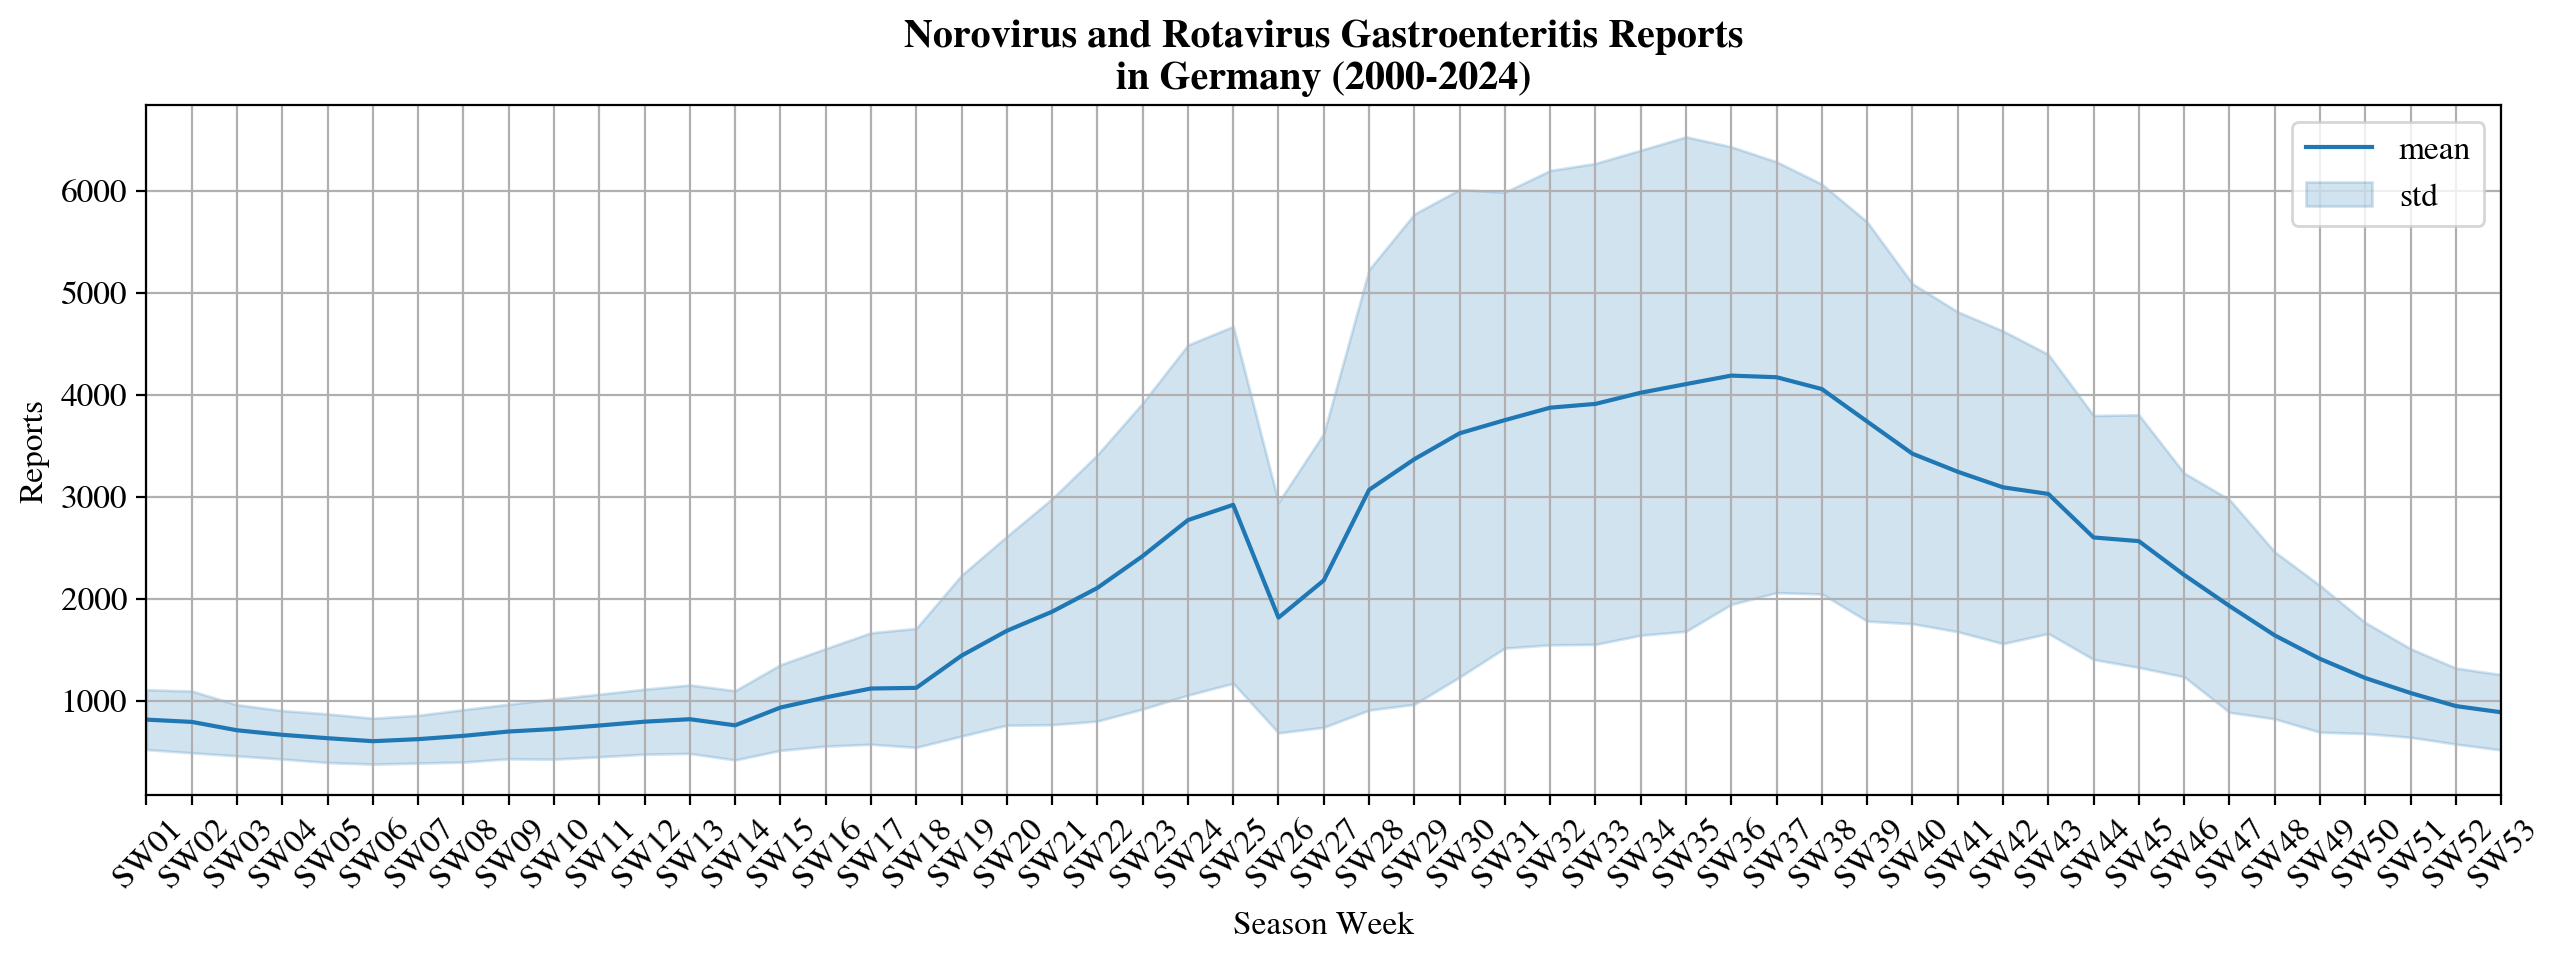

In [220]:
# Plot Aggregation of all + uncertainty (test std and confidence intervals)
fig, ax = plt.subplots(figsize=(13, 5))
sns.lineplot(
    data=df_temp.sort_values("seasonWeek"),
    x="seasonWeek",
    y="reports",
    ax=ax,
    errorbar="sd",
    label="mean",
    err_kws={"label": "std"},
)
ax.set(
    title="Norovirus and Rotavirus Gastroenteritis Reports\nin Germany (2000-2024)",
    xlabel="Season Week",
    ylabel="Reports",
    xlim=(0, 52),
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

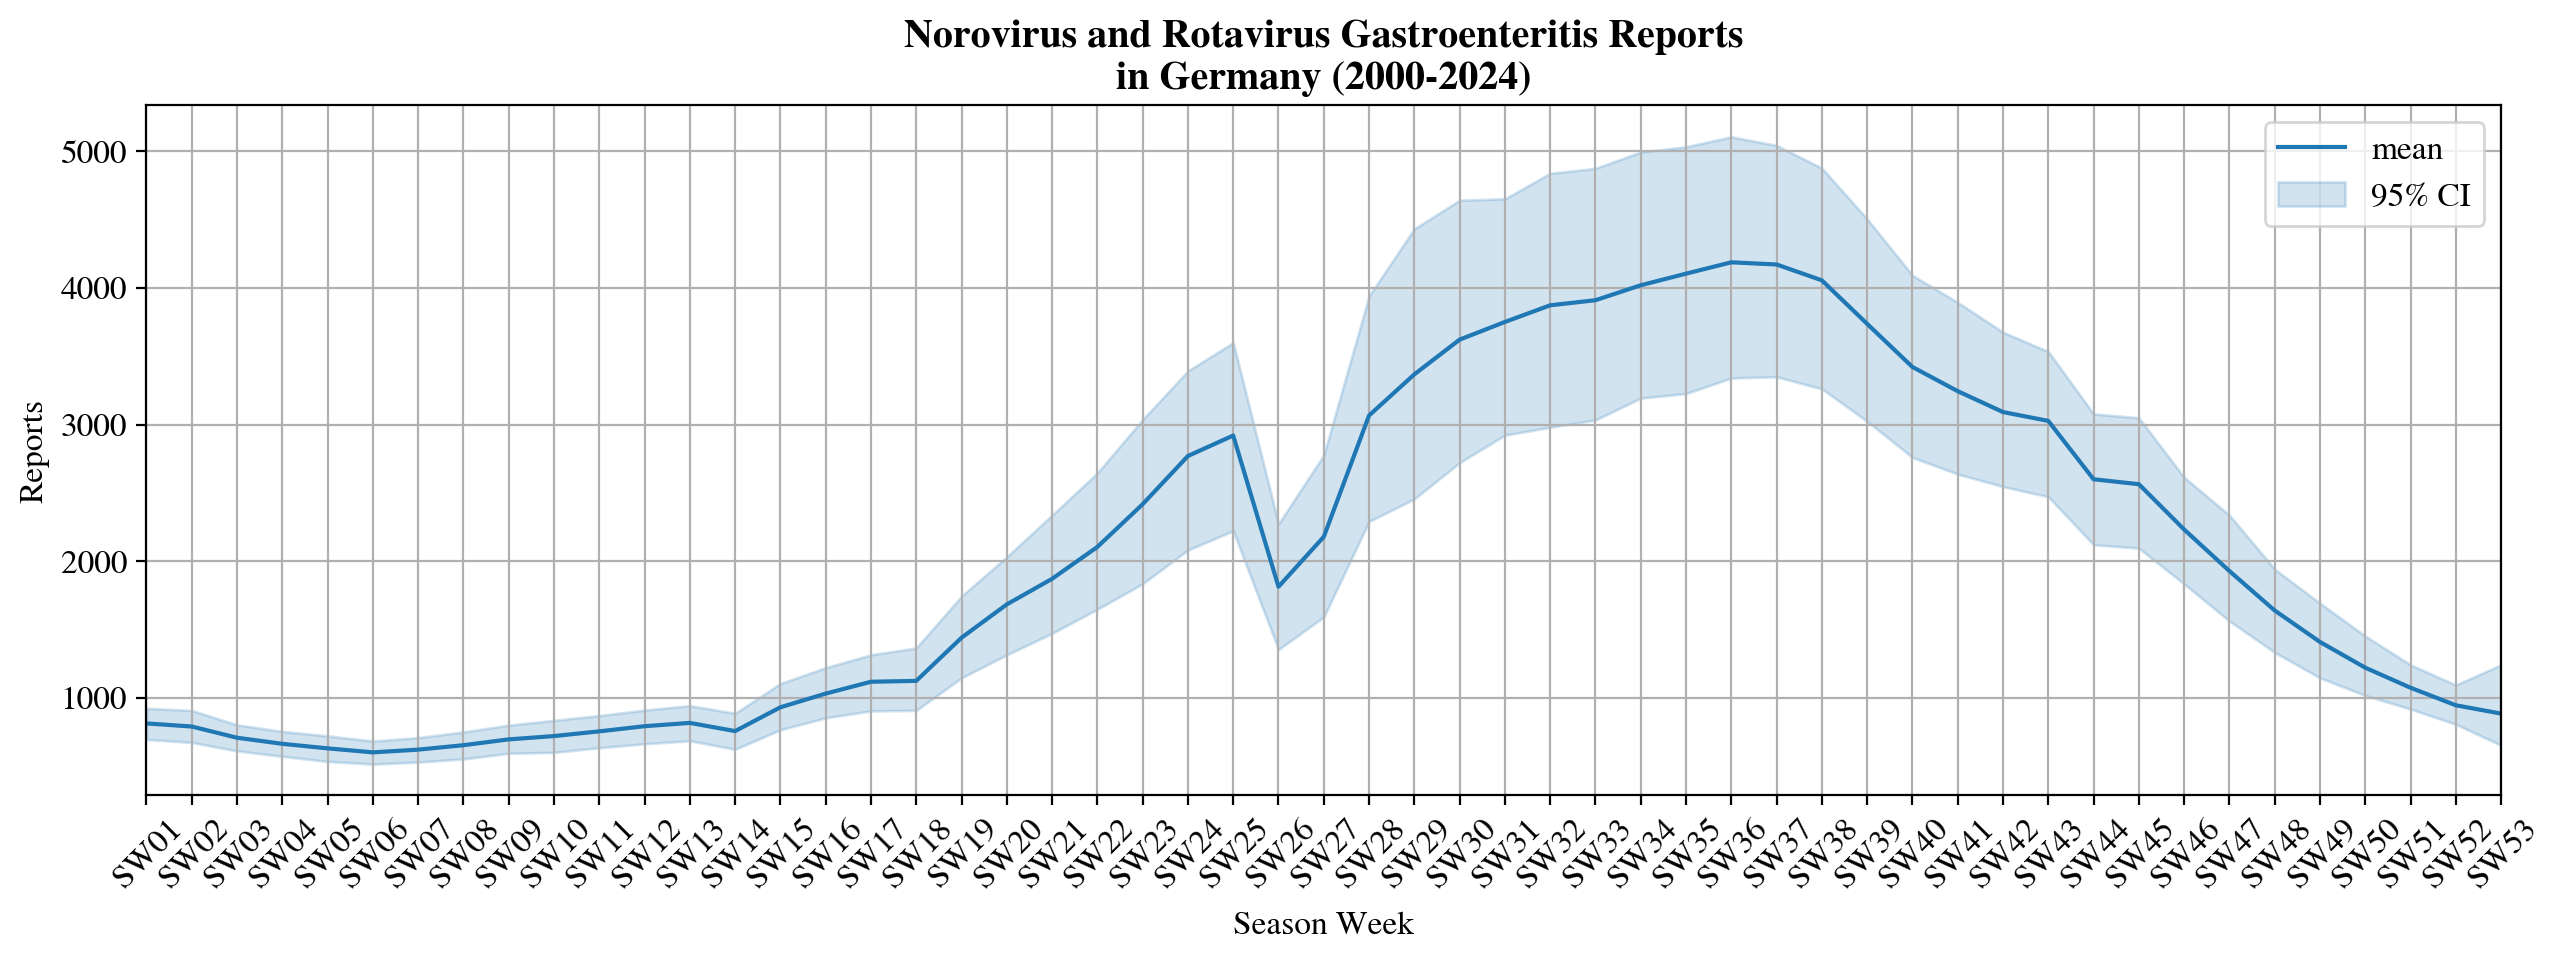

In [221]:
# Plot Aggregation of all + uncertainty (test std and confidence intervals)
fig, ax = plt.subplots(figsize=(13, 5))
sns.lineplot(
    data=df_temp.sort_values("seasonWeek"),
    x="seasonWeek",
    y="reports",
    ax=ax,
    errorbar=("ci", 95),
    label="mean",
    err_kws={"label": "95% CI"},
)
ax.set(
    title="Norovirus and Rotavirus Gastroenteritis Reports\nin Germany (2000-2024)",
    xlabel="Season Week",
    ylabel="Reports",
    xlim=(0, 52),
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()